In [18]:
import hashlib
import math
import matplotlib.pyplot as plt
import re
import requests
import seaborn as sns
import statistics

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
%matplotlib inline
tf.random.set_seed(123)

In [4]:
print("Running TensorFlow {}".format(tf.__version__))

Running TensorFlow 2.1.0


In [5]:
URL = "https://zenodo.org/record/841301/files/FORTH_TRACE_DATASET.zip?download=1"
MD5SUM = "3171a6f4be066ecbac0840e7842df710"

COLUMNS=['DeviceID',
         'AccelerometerX',
         'AccelerometerY',
         'AccelerometerZ',
         'GyroscopeX',
         'GyroscopeY',
         'GyroscopeZ',
         'MagnetometerX',
         'MagnetometerY',
         'MagnetometerZ',
         'Timestamp',
         'ActivityLabel']

FEATURES = COLUMNS[:-2]
DEVICE = COLUMNS[0]
TIME = COLUMNS[-2]
ACTIVITY = COLUMNS[-1]

In [6]:
#r = urlopen(URL)
r = requests.get(URL, stream=True)
if hashlib.md5(r.content).hexdigest() != MD5SUM:
    exit()

#zipfile = ZipFile(BytesIO(r.read()))
zipfile = ZipFile(BytesIO(r.content))

In [7]:
filter_dev2 = list(filter(lambda k: 'dev2' in k, zipfile.namelist()))
pattern = re.compile('.*\/part(\d{1,2})\/.*')

har_participants = dict()
for p in filter_dev2:
    har_participants[pattern.search(p).group(1)] = pd.read_csv(zipfile.open(p), header=None, names=COLUMNS)
    
har_participants_steady = dict()
# Steady activities correspond to activities 1 to 5
for k, v in har_participants.items():
    har_participants_steady[k] = v[v[ACTIVITY] < 6]

In [8]:
# Examine one of the participants data steady activities
har_0_steady = har_participants_steady[str(0)]
har_0_steady.tail()

,DeviceID,AccelerometerX,AccelerometerY,AccelerometerZ,GyroscopeX,GyroscopeY,GyroscopeZ,MagnetometerX,MagnetometerY,MagnetometerZ,Timestamp,ActivityLabel
52859,2,2.3837,9.0681,3.4339,-0.429610,-1.75440,-0.300480,0.35197,0.88294,0.69737,1039200.0,1
52860,2,2.4075,8.9945,3.3985,-0.279800,-1.72390,0.129850,0.35197,0.86706,0.69079,1039200.0,1
52861,2,2.3837,9.0316,3.4346,-0.043147,-0.77803,0.195980,0.32919,0.84722,0.69956,1039300.0,1
52862,2,2.3236,9.0922,3.4472,-0.125830,-0.56445,-0.016121,0.33747,0.88889,0.70614,1039300.0,1
52863,2,2.2991,9.1032,3.3996,-0.532890,-1.52560,0.026206,0.33333,0.82937,0.69737,1039300.0,1


/Users/grodriguezcano/.virtualenvs/human-activity-recognition/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/grodriguezcano/.virtualenvs/human-activity-recognition/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/grodriguezcano/.virtualenvs/human-activity-recognition/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subp

array([<matplotlib.axes._subplots.AxesSubplot object at 0x139838f10>,
      dtype=object)

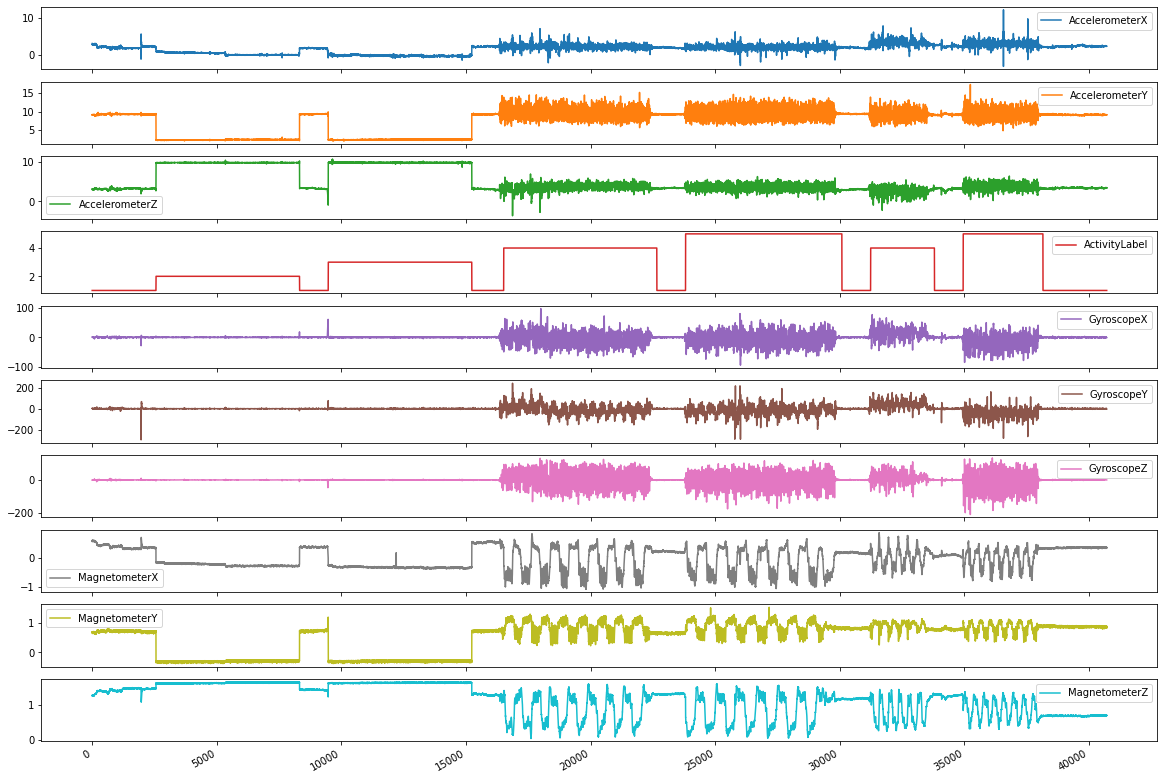

In [9]:
# Plot one of the participants data steady activities
# har_0_steady.set_index(TIME).reset_index()[har_0_steady.columns.difference([DEVICE, TIME, ACTIVITY])].plot(subplots=True, figsize=(20, 15))
har_0_steady.set_index(TIME).reset_index()[har_0_steady.columns.difference([DEVICE, TIME])].plot(subplots=True, figsize=(20, 15))

In [10]:
# Group and split sensors' data per activity per participant
har_partipants_steady_activities = dict()
for k, v in har_participants_steady.items():
    group_cond = v[ACTIVITY].ne(v[ACTIVITY].shift()).cumsum()
    har_partipants_steady_activities[k] = [v for k, v in v.groupby(group_cond)]

In [43]:
# Get minimum and maximum sizes of data events collected per activity
activities_sizes = list()
for k, v in har_partipants_steady_activities.items():
    for e in v:
        activities_sizes.append(len(e.index))

print(pd.DataFrame(activities_sizes).describe())
print(pd.DataFrame(activities_sizes).quantile([e / 10 for e in range(1, 10)]))

                 0
count   195.000000
mean   3104.112821
std    2043.550563
min     384.000000
25%    1153.000000
50%    2689.000000
75%    5632.000000
max    6785.000000
          0
0.1  1025.0
0.2  1152.0
0.3  1153.0
0.4  1869.4
0.5  2689.0
0.6  3201.0
0.7  4352.2
0.8  5760.0
0.9  6145.0


In [ ]:
TRAIN = math.ceil(len(har_0_steady.index)*0.7)
VALIDATION = math.ceil(len(har_0_steady.index)*0.2)
TEST = len(har_0_steady.index) - (TRAIN + VALIDATION)

In [ ]:
data = har_0_steady.set_index(TIME).reset_index()[har_0_steady.columns.difference([DEVICE, TIME, ACTIVITY])]

dataset = data.values
data_mean = dataset[:TRAIN].mean(axis=0)
data_std = dataset[:TRAIN].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [ ]:
data_gen = TimeseriesGenerator(np.array(har_0_steady.set_index(TIME).reset_index()[har_0_steady.columns.difference([DEVICE, TIME, ACTIVITY])]),
                               np.array(har_0_steady.set_index(TIME).reset_index()[[ACTIVITY]]),
                               length=9, sampling_rate=1,
                               batch_size=2)

In [ ]:
n_timesteps = 1
n_features = 9
n_outputs = 5

model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(100, input_shape=(n_timesteps, n_features)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
steps=len(har_0_steady.index)/2
model.fit(data_gen, steps_per_epoch=steps, epochs=3, verbose=2)

In [ ]:
2 > int(None)